In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
import seaborn as sns
from scipy.stats import mode
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score


### Image Data Preprocessing with `load_data` Function

This code defines a function, `load_data`, to preprocess and load image data from a specified folder path. The function reads images, converts them to RGB, resizes them to a consistent size, normalizes pixel values, and stores them as NumPy arrays. The function returns data and labels arrays. The example usage demonstrates loading data from a folder and printing the shapes of the resulting arrays.


In [3]:
from PIL import Image
import os
import numpy as np

def load_data(train_folder_path, target_size=(224, 224)):
    data = []
    labels = []

    classes = os.listdir(train_folder_path)
    
    for i, class_name in enumerate(classes):
        class_path = os.path.join(train_folder_path, class_name)
        images = os.listdir(class_path)

        for image in images:
            image_path = os.path.join(class_path, image)
            # Load the image data using PIL
            with Image.open(image_path) as img:
                # Convert the image to RGB
                img = img.convert('RGB')
                # Resize the image to a consistent size
                img = img.resize(target_size)
                # Convert the image to a NumPy array
                image_data = np.array(img)
                image_data = image_data/255
            
            # Append image data and label to lists
            data.append(image_data)
            labels.append(i)

    data = np.array(data)
    labels = np.array(labels)
    print(data.shape, labels.shape)
    return data, labels

# Example usage
train_folder_path = "C:\\Users\\Himanshu\\Desktop\\SML_CNN\\final_dataset"
data, labels = load_data(train_folder_path)


(5954, 224, 224, 3) (5954,)


### Loading and Splitting Image Data

This code snippet loads image data from a specified folder path, prints the shapes of the data and labels, and performs a train-test split using `train_test_split` from scikit-learn. The resulting shapes of the training and testing datasets are then printed in bold.


In [4]:
print(data.shape, labels.shape)
#Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=10)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5954, 224, 224, 3) (5954,)
(4167, 224, 224, 3) (1787, 224, 224, 3) (4167,) (1787,)


### Fine-tuning with ResNet50 for Image Classification

This code employs transfer learning using the pre-trained ResNet50 model for image classification. The key steps include:

1. **Load Pre-trained ResNet50 Model:**
   - Utilizes the ResNet50 model pre-trained on ImageNet, excluding the top layers for feature extraction.

2. **Unfreeze Layers for Fine-tuning:**
   - Unfreezes the last few layers of the ResNet50 model to allow for fine-tuning.

3. **Create New Sequential Model:**
   - Constructs a new Sequential model and adds the pre-trained ResNet50 as its base.

4. **Resize Input Images:**
   - Implements a resize function to preprocess input images, ensuring compatibility with the ResNet50 model's input shape.

5. **Flatten and Add Fully Connected Layers:**
   - Introduces a Flatten layer followed by fully connected layers for classification.

6. **Compile the Model:**
   - Compiles the model with binary crossentropy loss, Adam optimizer, and accuracy as the evaluation metric.


In [10]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from skimage.transform import resize

# Load the pre-trained ResNet50 model (excluding the top layers)
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the last few layers for fine-tuning
for layer in resnet_model.layers[:-10]:
    layer.trainable = True


# Create a new model
model = Sequential()

# Add the pre-trained ResNet50 model
model.add(resnet_model)

# Resize function
def preprocess_input(img):
    img = resize(img, (224, 224, 3))
    return img

# Apply resize function to input images
X_train_resized = np.array([preprocess_input(img) for img in X_train])
X_test_resized = np.array([preprocess_input(img) for img in X_test])

# Flatten layer
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [11]:
epochs = 10
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))
model.save("my_model122.h5")

Epoch 1/10
131/131 [==============================] - 826s 6s/step - loss: 2.1874 - accuracy: 0.6808 - val_loss: 1.4192 - val_accuracy: 0.4930
Epoch 2/10
131/131 [==============================] - 719s 5s/step - loss: 0.4663 - accuracy: 0.7833 - val_loss: 5.7004 - val_accuracy: 0.4930
Epoch 3/10
131/131 [==============================] - 732s 6s/step - loss: 0.3531 - accuracy: 0.8560 - val_loss: 5.5440 - val_accuracy: 0.4930
Epoch 4/10
131/131 [==============================] - 730s 6s/step - loss: 0.2780 - accuracy: 0.8906 - val_loss: 0.9737 - val_accuracy: 0.4930
Epoch 5/10
131/131 [==============================] - 733s 6s/step - loss: 0.2513 - accuracy: 0.9028 - val_loss: 1.0720 - val_accuracy: 0.4941
Epoch 6/10
131/131 [==============================] - 729s 6s/step - loss: 0.2092 - accuracy: 0.9222 - val_loss: 2.6690 - val_accuracy: 0.5260
Epoch 7/10
131/131 [==============================] - 731s 6s/step - loss: 0.1533 - accuracy: 0.9426 - val_loss: 0.9988 - val_accuracy: 0.6637

C:\Users\Himanshu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Model Evaluation

The code predicts labels (`y_pred`) and probabilities (`y_pred_prob`) using the trained model on the test set. The following evaluations are performed:

1. **Accuracy Calculation:**
   - Accuracy is computed using the predicted and actual labels on the test set.

2. **Classification Report:**
   - Displays precision, recall, and F1-score for each class.

3. **Confusion Matrix:**
   - Generates a confusion matrix with annotated values, providing insights into true and predicted values.

4. **F1 Score:**
   - Computes the F1 score as an additional performance metric.

56/56 [==============================] - 87s 2s/step
Model Accuracy on Test Set: 0.846670397313934

 Classification report : 
               precision    recall  f1-score   support

           0       0.79      0.94      0.86       906
           1       0.92      0.75      0.83       881

    accuracy                           0.85      1787
   macro avg       0.86      0.85      0.84      1787
weighted avg       0.86      0.85      0.85      1787

Accuracy   Score :  0.846670397313934
F1 Score:  0.8283208020050125


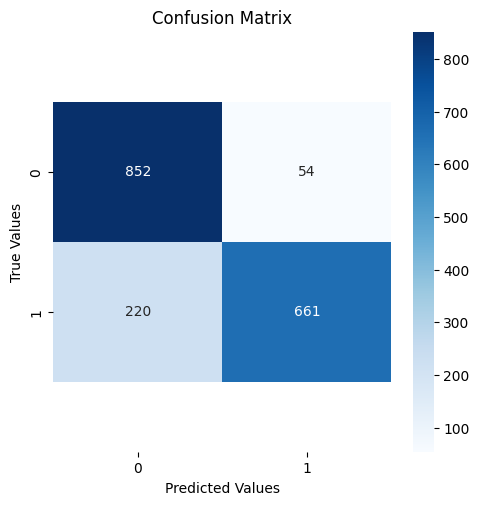

In [15]:

y_pred_prob = model.predict(X_test)

y_pred = (y_pred_prob > 0.5).astype(int)
 
# Evaluate the model

accuracy = accuracy_score(y_test, y_pred)

print(f'Model Accuracy on Test Set: {accuracy}')
 
print ("\n Classification report : \n",classification_report (y_test, y_pred))

print ("Accuracy   Score : ",accuracy_score (y_test, y_pred))
 
#Generate confusion-matrix as below

conf_matrix = confusion_matrix (y_test, y_pred)

plt.figure (figsize=(12,12))

plt.subplot (221)

sns.heatmap (conf_matrix, fmt = "d", annot=True, cmap='Blues')

b, t = plt.ylim()

plt.ylim (b + 0.5, t - 0.5)

plt.ylabel ('True Values')

plt.title ('Confusion Matrix')

plt.xlabel ('Predicted Values')
 
#Generate F1-score as below

f1 = f1_score (y_test, y_pred)

print ("F1 Score: ", f1)

### Summary
This Notebooke implements transfer learning using the ResNet50 model pre-trained on ImageNet for image classification. The pre-trained ResNet50 is incorporated into a new Sequential model with unfrozen last layers for fine-tuning. Input images are resized, and the model is extended with a Flatten layer, followed by fully connected layers. The final model is compiled with binary crossentropy loss and the Adam optimizer. This approach leverages the powerful feature extraction capabilities of ResNet50, enabling effective image classification with the flexibility to fine-tune model parameters.